20210313_21-0043-1_060_5min5min_100 cycles 12-03-2021 09-43-09.xlsx
Importing data from the file...
Instrument: DVS-Vacuum
Sample mass: 6.8458
Sorption Temp. [celsius]: 22.53 +- 29.06
120
120


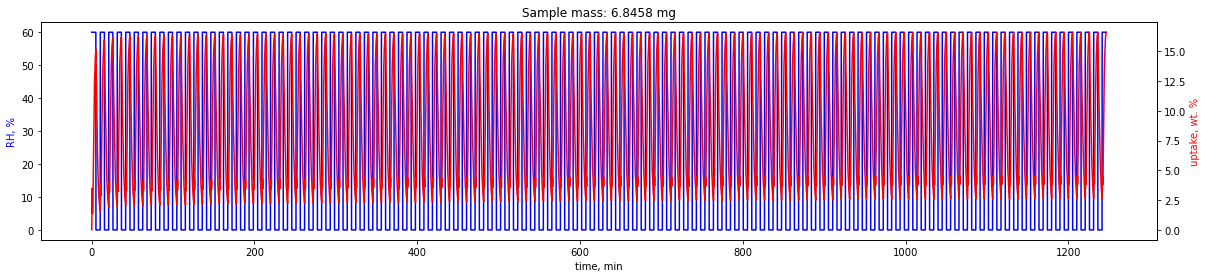

20210421_19-0182-4_ROS-037P_060_5min5min_100cycles 21-04-2021 18-30-43.xlsx
Importing data from the file...
Instrument: DVS-Vacuum
Sample mass: 6.8191
Sorption Temp. [celsius]: 21.86 +- 28.88
120
120


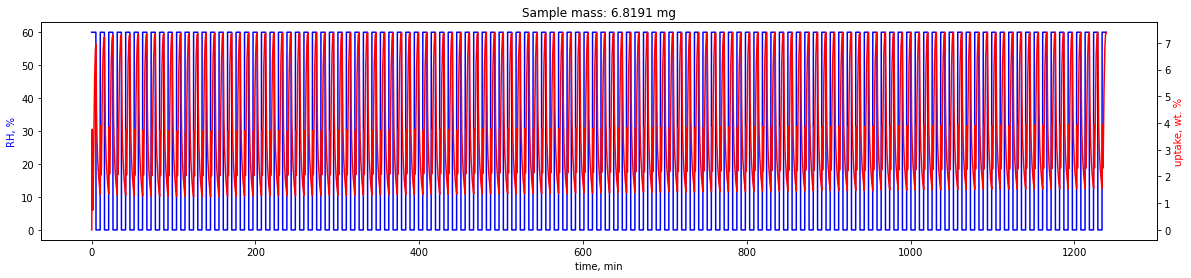

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 14 16:46:49 2021

@author: Andrey.Bezrukov
"""

# loading libraries
import numpy  as np                
import pandas as pd
import matplotlib.pyplot as plt   
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import os
import math as m

##################################################
####### import function 
##################################################

def import_data(filename):
    ## import data
    try:
        df = pd.read_excel(filename, sheet_name='DVS Data')
    except: 
        raise CannotReadFile("Pandas cannot read the file")
    if df.columns[0] == 'DVS-INTRINSIC DATA FILE':
        instrument = df.columns[0].split()[0]
        sample_mass = df.iloc[4, 7]
        print('Importing data from the file...')
        print('Instrument: {0}'.format(instrument))
        print('Sample mass: {0}'.format(sample_mass))
        
        df.columns = df.iloc[22, :]
        df = df.iloc[23:, :]
        df = df.reset_index(drop=True)
        df = df.astype('float')
        print('Target Balance Head Temp: {0} +- {1}'.format(df.iloc[:,6].mean(), df.iloc[:,6].std()))
        if df.iloc[:,0].count()/(df.iloc[:,0].max()-df.iloc[:,0].min())< 5:
            print('Warning! Data resolution is low! (below 5 points per minute)')
            sg.popup('Warning!',  'Data resolution is low! (below 5 points per minute)')
        # renaming columns to common notation
        df = df[['Time (min)', 'dm (%) - ref', 'Target RH (%)', 'Actual RH (%)', 'Target Sample Temp', 'Actual Sample Temp']]
        df.columns = ['time', 'uptake', 'target_RH', 'actual_RH', 'target_temp', 'actual_temp']
    
    elif df.columns[0] == 'DVS-Advantage-Plus-Data-File':
        instrument = df.columns[0][:-10]
        sample_mass = df.iloc[27, 1]
        print('Importing data from the file...')
        print('Instrument: {0}'.format(instrument))
        print('Sample mass: {0}'.format(sample_mass))
        
        df.columns = df.iloc[39, :]
        df = df.iloc[40:, :30]
        df = df.reset_index(drop=True)
        df = df[[i for i in df.columns if (i == i) & (i != 'Chiller State')]]
        df = df.astype('float')
        print('Sorption Temp. [celsius]: {0:.2f} +- {1:.2f}'.format(df.iloc[:,8].mean(), df.iloc[:,8].std()))
        if df.iloc[:,0].count()/(df.iloc[:,0].max()-df.iloc[:,0].min())< 5:
            print('Warning! Data resolution is low! (below 5 points per minute)')
            sg.popup('Warning!',  'Data resolution is low! (below 5 points per minute)')
        # renaming columns to common notation
        df = df[['Time [minutes]', 'dm (%) - ref', 'Target Partial Pressure (Solvent A) [%]', 'Measured Partial Pressure (Solvent A) [%]', 'Target Incubator Temp. [celsius]', 'Sorption Temp. [celsius]']]
        df.columns = ['time', 'uptake', 'RH_target', 'RH', 'target_temp', 'actual_temp']
    elif df.columns[0] == 'DVS-Vacuum-Data-File':
        instrument = df.columns[0][:-10]
        sample_mass = df.iloc[9, 1]
        print('Importing data from the file...')
        print('Instrument: {0}'.format(instrument))
        print('Sample mass: {0}'.format(sample_mass))
        
        df.columns = df.iloc[40, :]
        df = df.iloc[41:, :30]
        df = df.reset_index(drop=True)
        df = df[[i for i in df.columns if (i == i) & (i != 'Chiller State')]]
        df = df.astype('float')
        print('Sorption Temp. [celsius]: {0:.2f} +- {1:.2f}'.format(df.iloc[:,8].mean(), df.iloc[:,8].std()))
        if df.iloc[:,0].count()/(df.iloc[:,0].max()-df.iloc[:,0].min())< 5:
            print('Warning! Data resolution is low! (below 5 points per minute)')
            sg.popup('Warning!',  'Data resolution is low! (below 5 points per minute)')
        # renaming columns to common notation
        df = df[['Time [minutes]', 'dm (%) - ref', 'Target Relative Pressure [%]', 'Actual Relative Pressure [%]',\
                 'Target Incubator Temperature [°C]', 'Actual Preheater Temperature [°C]']]
        df.columns = ['time', 'uptake', 'RH_target', 'RH', 'target_temp', 'actual_temp']
    else:
        raise CannotReadFile("Wrong File Format")
    return df, instrument, sample_mass

path = '../../data/100_cycles/'

filelist = ['20210313_21-0043-1_060_5min5min_100 cycles 12-03-2021 09-43-09.xlsx',
            '20210421_19-0182-4_ROS-037P_060_5min5min_100cycles 21-04-2021 18-30-43.xlsx',
           ]

##################################################
####### import kinetics data 
##################################################

for n, filename  in enumerate(filelist):
    print(filename)

    df, instrument, sample_mass = import_data(path+filename)
    df['cycle_split'] = df['RH_target'].diff().fillna(0)
    split_index_ads = df.index[(df['cycle_split']>0)].tolist()
    split_index_des = df.index[(df['cycle_split']<0)].tolist()
    print(len(split_index_ads))
    print(len(split_index_des))
    fig, ax1 = plt.subplots(figsize=(20, 4))
    ax1.plot(df[split_index_ads[0]:split_index_des[-1]].time-df.iloc[split_index_ads[0], :].time, 
             df[split_index_ads[0]:split_index_des[-1]].RH_target, c='b',
             label=filename)
    ax2 = ax1.twinx()
    ax2.plot(df[split_index_ads[0]:split_index_des[-1]].time-df.iloc[split_index_ads[0], :].time, 
             df[split_index_ads[0]:split_index_des[-1]].uptake, c='r', 
             label=filename)
    ax1.set_xlabel('time, min')
    ax2.set_ylabel('uptake, wt. %', c='r')
    ax1.set_ylabel('RH, %', c='b')
    ax1.set_title('Sample mass: {0} mg'.format(sample_mass))
    #plt.savefig('120cycles_{0}.png'.format(filename), dpi=300)
    plt.show()
